# Semantic Segmentation 

In [17]:
img_width = 256
img_array_len = img_width * img_width

In [18]:

def decrease_highlights(image, highlight_threshold=200):
    # Convert the image to grayscale if it's not already
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Identify pixels above the highlight threshold and reduce their intensity
    mask = image > highlight_threshold
    decreased_image = np.copy(image)
    decreased_image[mask] = highlight_threshold

    return decreased_image


def increase_contrast(image):
    # Convert the image to grayscale if it's not already
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply histogram equalization
    equalized_image = cv2.equalizeHist(image)

    return equalized_image

In [19]:
import os
import cv2
import numpy as np

def loading_data(basePath, xs=256):
    x_list = []
    
    imgNames = os.listdir(basePath)

    for img_name in imgNames:
        img_path = os.path.join(basePath, img_name)
        img = cv2.imread(img_path)

        if img is not None:
            img_size = (xs, xs)
            img = cv2.resize(img, img_size)

            # contrast_decreased_image = img

            contrast_decreased_image = decrease_highlights(img)
            contrast_decreased_image = increase_contrast(contrast_decreased_image)

            # Ensure the image has 3 channels (for color images)
            if contrast_decreased_image.shape[-1] != 3:
                # Convert to RGB if the image is not already in that format
                contrast_decreased_image = cv2.cvtColor(contrast_decreased_image, cv2.COLOR_BGR2RGB)

            # Normalize pixel values to be between 0 and 1
            img_normalized = contrast_decreased_image.astype('float32') / 255.0

            # Add the preprocessed image to the list
            x_list.append(img_normalized)
        else:
            print(f"Warning: Unable to read image from {img_path}")

    # Convert the list of images to a NumPy array
    x_list = np.array(x_list)

    return x_list


In [20]:
# Training images: 
basePath = 'Amazon Forest Dataset/data/Training/images'
x_train = loading_data(basePath, xs = img_width)


basePath_masks = 'Amazon Forest Dataset/data/Training/masks'
x_train_masks = loading_data(basePath, xs = img_width)

len(x_train[0])
print("Shape of x_train:", x_train.shape)


# Validation images: 
basePath = 'Amazon Forest Dataset/data/Validation/images'
x_val = loading_data(basePath, xs = img_width)

basePath_masks = 'Amazon Forest Dataset/data/Validation/masks'
x_val_masks = loading_data(basePath, xs = img_width)


len(x_val[0])

Shape of x_train: (30, 256, 256, 3)


256

In [21]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def convolutional_block(x, filters, kernel_size, strides=1, padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, activation='relu')(x)
    return x

def transpose_convolutional_block(x, filters, kernel_size, strides=1, padding='same'):
    x = Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding, activation='relu')(x)
    return x

def segmentation_autoencoder(input_shape, base=8):
    inputs = Input(shape=input_shape)

    # Encoder
    x = convolutional_block(inputs, base, 3, padding='same')
    x = convolutional_block(x, 2 * base, 4, strides=2, padding='same')
    x = convolutional_block(x, 4 * base, 4, strides=2, padding='same')
    x = convolutional_block(x, 8 * base, 4, strides=2, padding='same')

    # Decoder
    x = transpose_convolutional_block(x, 4 * base, 4, strides=2, padding='same')
    x = transpose_convolutional_block(x, 2 * base, 4, strides=2, padding='same')
    x = transpose_convolutional_block(x, base, 4, strides=2, padding='same')
    x = Conv2D(1, 3, padding='same', activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

# Define the input shape (adjust based on your data)
input_shape = (256, 256, 3)

# Creating the model
model = segmentation_autoencoder(input_shape)

# model summary
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 256, 256, 8)       224       
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 16)      2064      
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 32)        8224      
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 64)        32832     
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 64, 64, 32)        32800     
 Transpose)                                                      
                                                           

In [22]:
from tensorflow.keras.optimizers import Adam

# Define the input shape
input_shape = (256, 256, 3)

# Create the model
model = segmentation_autoencoder(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
epochs = 100  
batch_size = 15  

history = model.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(x_val, x_val))


Epoch 1/100
2/2 [==============================] - 4s 1s/step - loss: 0.0805 - val_loss: 0.0793
Epoch 2/100
2/2 [==============================] - 2s 941ms/step - loss: 0.0804 - val_loss: 0.0793
Epoch 3/100
2/2 [==============================] - 2s 861ms/step - loss: 0.0803 - val_loss: 0.0791
Epoch 4/100
2/2 [==============================] - 2s 1s/step - loss: 0.0801 - val_loss: 0.0789
Epoch 5/100
2/2 [==============================] - 2s 1s/step - loss: 0.0798 - val_loss: 0.0782
Epoch 6/100
2/2 [==============================] - 2s 958ms/step - loss: 0.0790 - val_loss: 0.0767
Epoch 7/100
2/2 [==============================] - 2s 1s/step - loss: 0.0771 - val_loss: 0.0734
Epoch 8/100
2/2 [==============================] - 2s 985ms/step - loss: 0.0739 - val_loss: 0.0700
Epoch 9/100
2/2 [==============================] - 3s 2s/step - loss: 0.0729 - val_loss: 0.0705
Epoch 10/100
2/2 [==============================] - 2s 1s/step - loss: 0.0720 - val_loss: 0.0686
Epoch 11/100
2/2 [=========

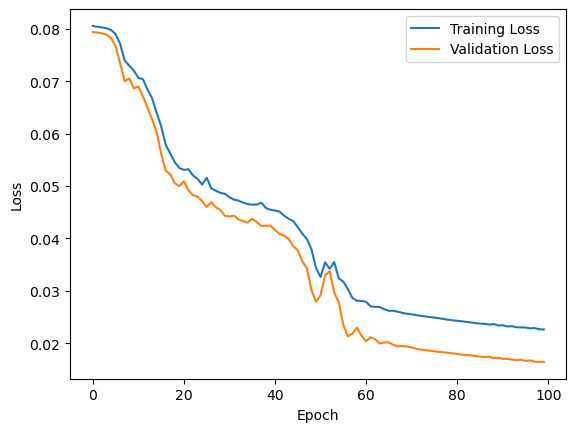

In [23]:
import matplotlib.pyplot as plt 

# plt training and validation loss
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 338ms/step


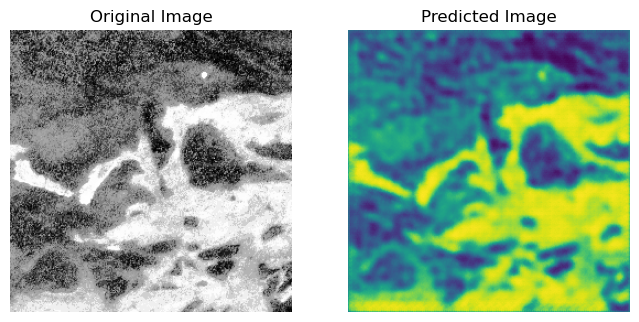

In [24]:
import matplotlib.pyplot as plt
import random

# Getting a random image from x_train 
random_index = random.randint(0, len(x_train) - 1)
input_image = x_train[random_index]

# Reshaping for prediction
input_image_reshaped = np.expand_dims(input_image, axis=0)

# PRedicting 
predicted_image = model.predict(input_image_reshaped)[0]

# Plot the original and predicted images
plt.figure(figsize=(8, 4))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title("Original Image")
plt.axis("off")

# Predicted Image
plt.subplot(1, 2, 2)
plt.imshow(predicted_image)
plt.title("Predicted Image")
plt.axis("off")

plt.show()


In [25]:
## Bolivia: 

# Training images: 
# basePath = 'Amazon Forest Dataset/data/Training/images'
basePAth_hungary = 'augmentation/hungry_test'

list_of_names = os.listdir(basePAth_hungary)

x_test = loading_data(basePAth_hungary, xs = img_width)

input_image = x_test[0]

len(list_of_names)
len(x_test)

5

Working on:  planet_medres_normalized_analytic_2017-06_2017-11_mosaic_654-935.png
1/1 [==============================] - 0s 43ms/step


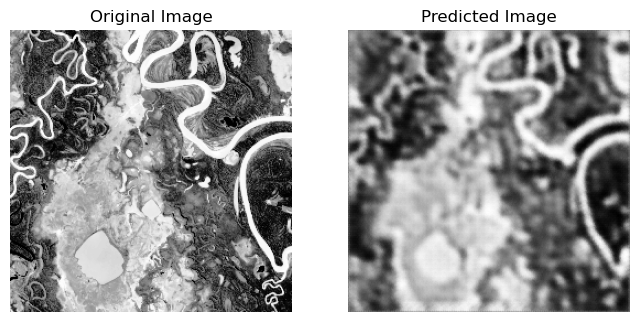

Working on:  planet_medres_normalized_analytic_2017-06_2017-11_mosaic_655-926.png
1/1 [==============================] - 0s 40ms/step


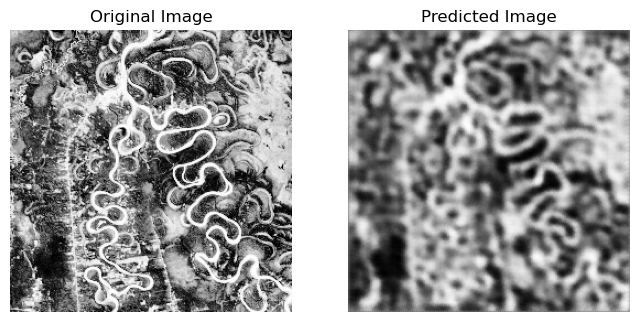

Working on:  planet_medres_normalized_analytic_2017-06_2017-11_mosaic_655-927.png
1/1 [==============================] - 0s 78ms/step


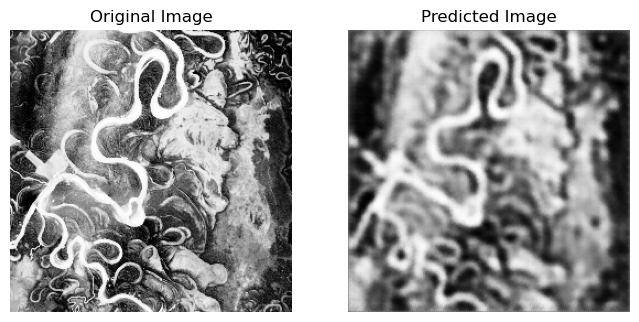

Working on:  planet_medres_normalized_analytic_2017-06_2017-11_mosaic_655-928.png
1/1 [==============================] - 0s 96ms/step


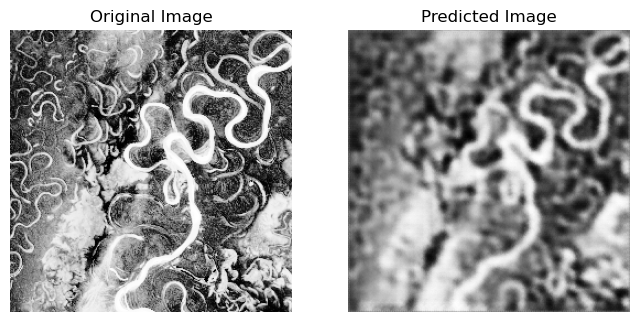

Working on:  planet_medres_normalized_analytic_2017-06_2017-11_mosaic_655-932.png
1/1 [==============================] - 0s 42ms/step


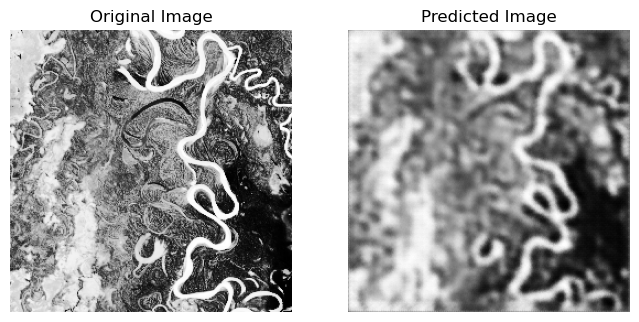

In [27]:

for img_index in range(len(x_test)):
    # Getting name:
    print("Working on: ", list_of_names[img_index])

    # Reshape the image to (1, height, width, channels) for prediction
    input_image = x_test[img_index]
    input_image_reshaped = np.expand_dims(input_image, axis=0)

    # Get the predicted image from the model
    predicted_image = model.predict(input_image_reshaped)[0]

    # Plot the original and predicted images
    plt.figure(figsize=(8, 4))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(input_image)
    plt.title("Original Image")
    plt.axis("off")

    # Predicted Image
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_image, cmap = 'gray')
    plt.title("Predicted Image")
    plt.axis("off")

    # Save the figure
    plt.savefig(f"result_image_grayed_" + list_of_names[img_index] + ".png")

    # Show the figure
    plt.show()